<a href="https://colab.research.google.com/github/LleilaA13/Thesis-MUL/blob/main/notebooks/feature_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Inversion Caricatures

This is the Lucent version of Lucid's [notebook](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/misc/feature_inversion_caricatures.ipynb) on feature inversion.

To quote from the Lucid notebook:

> This is slightly similar to the technique described by [Mahendran and Vedaldi](https://arxiv.org/pdf/1412.0035.pdf). However, we use a dot product objective, instead of L2 difference, and use transformation robustness to reduce artifacts.


## Install, Import, Load Model

In [1]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

from google.colab import files
uploaded = files.upload()


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Saving dog_cat.png to dog_cat.png


In [2]:
from PIL import Image
import numpy as np
import scipy.ndimage as nd
import torch

from google.colab import files

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1
from lucent.misc.io import show

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

Downloading: "https://github.com/ProGamerGov/pytorch-old-tensorflow-models/raw/master/inception5h.pth" to /root/.cache/torch/hub/checkpoints/inception5h.pth
100%|██████████| 27.0M/27.0M [00:00<00:00, 408MB/s]


## Setup Functions for Feature Inversion

We implement a dot product objective, to maximize the cosine similarity between the feature representations of a parameterized input and the target image.

In [4]:
@objectives.wrap_objective()
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = (T(layer)[batch] * T(layer)[0]).sum()
    mag = torch.sqrt(torch.sum(T(layer)[0]**2))
    cossim = dot/(1e-6 + mag)
    return -dot * cossim ** cossim_pow
  return inner

Then, we put everything together in a `feature_inversion` function.

In [9]:
def feature_inversion(img, layer=None, n_steps=512, cossim_pow=0.0):
  # Convert image to torch.tensor and scale image
  img = torch.tensor(np.transpose(img, [2, 0, 1])).to(device)
  upsample = torch.nn.Upsample(224)
  img = upsample(img)

  from torchvision import transforms
  resize = transforms.Resize((224, 224)) # Resize to 224x224
  img = resize(img) # Apply the resize transformation

  obj = objectives.Objective.sum([
    1.0 * dot_compare(layer, cossim_pow=cossim_pow),
    objectives.blur_input_each_step(),
  ])

  # Initialize parameterized input and stack with target image
  # to be accessed in the objective function
  params, image_f = param.image(224)
  def stacked_param_f():
    return params, lambda: torch.stack([image_f()[0], img])

  transforms = [
    transform.pad(8, mode='constant', constant_value=.5),
    transform.jitter(8),
    transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
    transform.random_rotate(list(range(-5, 5)) + [0]*5),
    transform.jitter(2),
  ]

  _ = render.render_vis(model, obj, stacked_param_f, transforms=transforms, thresholds=(n_steps,), show_image=False, progress=False)

  show(_[0][0])

## Run an Example!

Here we reproduce the Lucid example for all layers in InceptionV1.

In [10]:
img = np.array(Image.open("dog_cat.png"), np.float32)

layers = ['conv2d%d' % i for i in range(0, 3)] + \
         ['mixed3a', 'mixed3b', 'mixed4a',
          'mixed4b', 'mixed4c', 'mixed4d',
          'mixed4e', 'mixed5a', 'mixed5b']

conv2d0



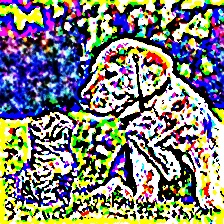


conv2d1



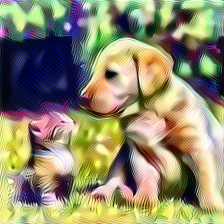


conv2d2



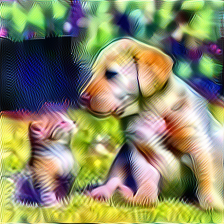


mixed3a



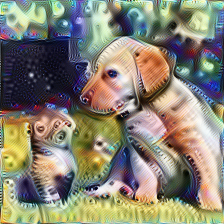


mixed3b



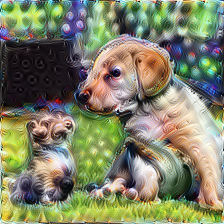


mixed4a



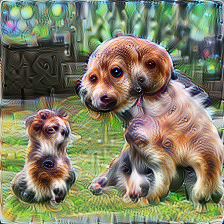


mixed4b



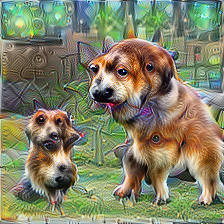


mixed4c



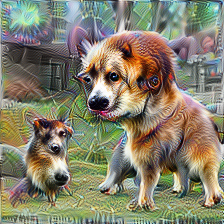


mixed4d



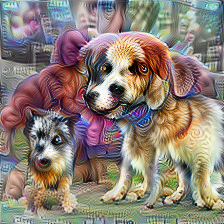


mixed4e



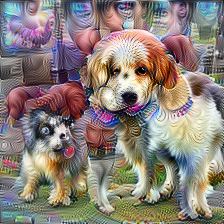


mixed5a



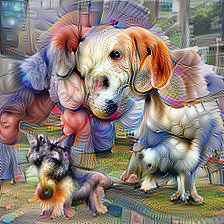


mixed5b



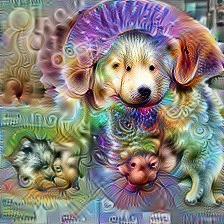

In [11]:
for layer in layers:
  print(layer)
  feature_inversion(img, layer=layer)
  print()

## Varying Cossine Similarity

Just like in the original Lucid notebook, we can also adjust the `cossim_pow` term in the `feature_inversion` function. Increasing the term encourages the output to be closer to the target's activations.

0.0



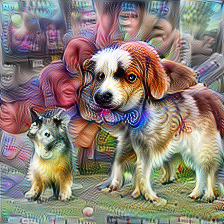


0.5



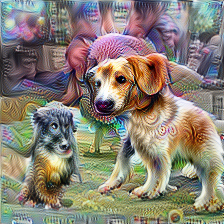


1.0



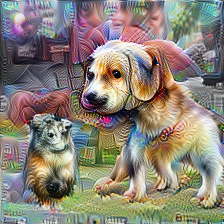


2.0



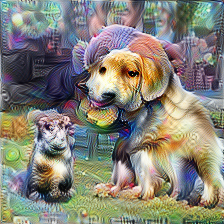

In [12]:
for cossim in [0.0, 0.5, 1.0, 2.0]:
  print(cossim)
  feature_inversion(img, layer='mixed4d', cossim_pow=cossim)
  print()

## Upload Your Own Image!

Saving cat.jpg to cat.jpg



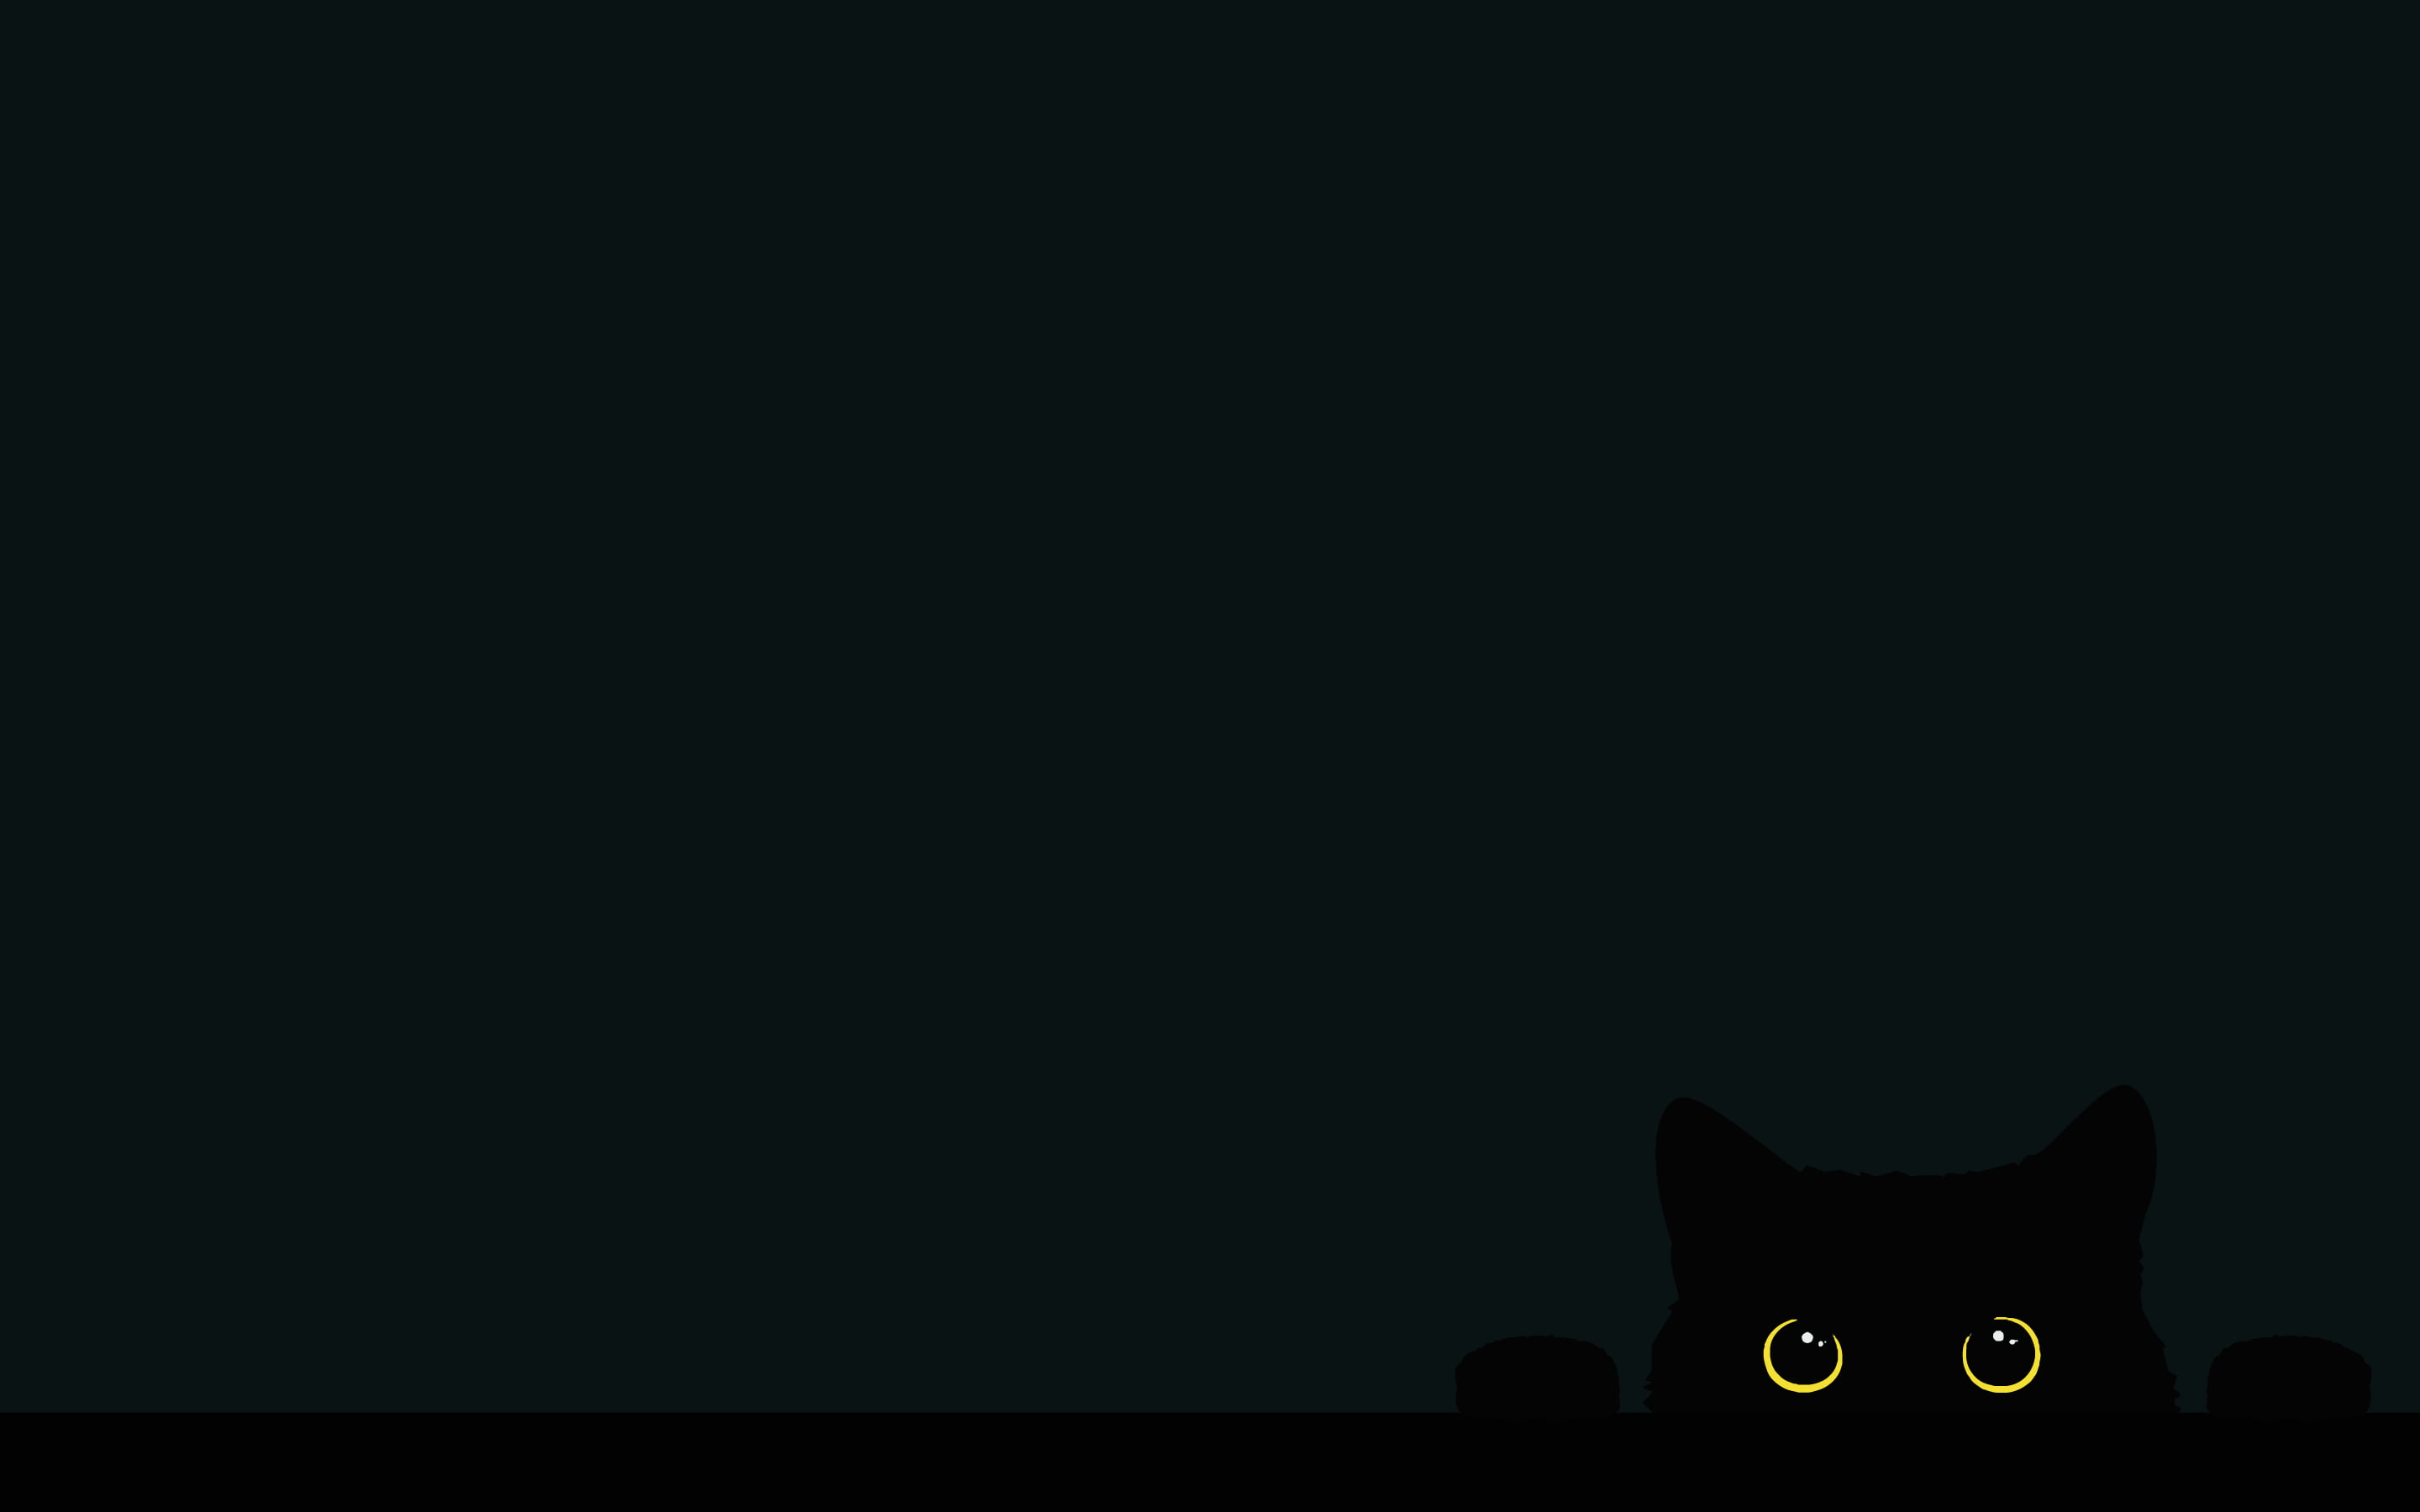


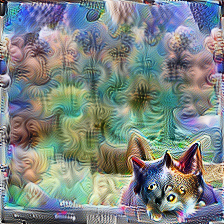

In [14]:
uploaded = files.upload()
for fn in uploaded.keys():
  img = np.array(Image.open(fn), np.float32)
  show(img/255)
  feature_inversion(img, layer='mixed4d')